In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from analysis_scripts import plot_3d_scan_data_2screens, plot_3d_scan_data_2screens_contour, create_clipped_dset

In [2]:
save_dir = '.'
dset = torch.load('clipped_dset.pt')

In [3]:
dset.params

tensor([[[[-2.9472e+00,  0.0000e+00, -2.2200e-16],
          [-2.9472e+00,  0.0000e+00, -1.1508e+00]],

         [[-2.9472e+00,  3.7000e+06, -2.2200e-16],
          [-2.9472e+00,  3.7000e+06, -1.1508e+00]]],


        [[[-2.2104e+00,  0.0000e+00, -2.2200e-16],
          [-2.2104e+00,  0.0000e+00, -1.1508e+00]],

         [[-2.2104e+00,  3.7000e+06, -2.2200e-16],
          [-2.2104e+00,  3.7000e+06, -1.1508e+00]]],


        [[[-1.4736e+00,  0.0000e+00, -2.2200e-16],
          [-1.4736e+00,  0.0000e+00, -1.1508e+00]],

         [[-1.4736e+00,  3.7000e+06, -2.2200e-16],
          [-1.4736e+00,  3.7000e+06, -1.1508e+00]]],


        [[[-7.3680e-01,  0.0000e+00, -2.2200e-16],
          [-7.3680e-01,  0.0000e+00, -1.1508e+00]],

         [[-7.3680e-01,  3.7000e+06, -2.2200e-16],
          [-7.3680e-01,  3.7000e+06, -1.1508e+00]]],


        [[[ 0.0000e+00,  0.0000e+00, -2.2200e-16],
          [ 0.0000e+00,  0.0000e+00, -1.1508e+00]],

         [[ 0.0000e+00,  3.7000e+06, -2.2200e-16],
     

In [4]:
dset.images.shape

torch.Size([9, 2, 2, 3, 300, 300])

In [5]:
# max intensity
vmax1 = dset.images[4,0,0].max()
print(vmax1)
vmax2 = dset.images[4,0,1].max()
print(vmax2)

tensor(0.0021)
tensor(0.0010)


(<Figure size 2000x1000 with 50 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

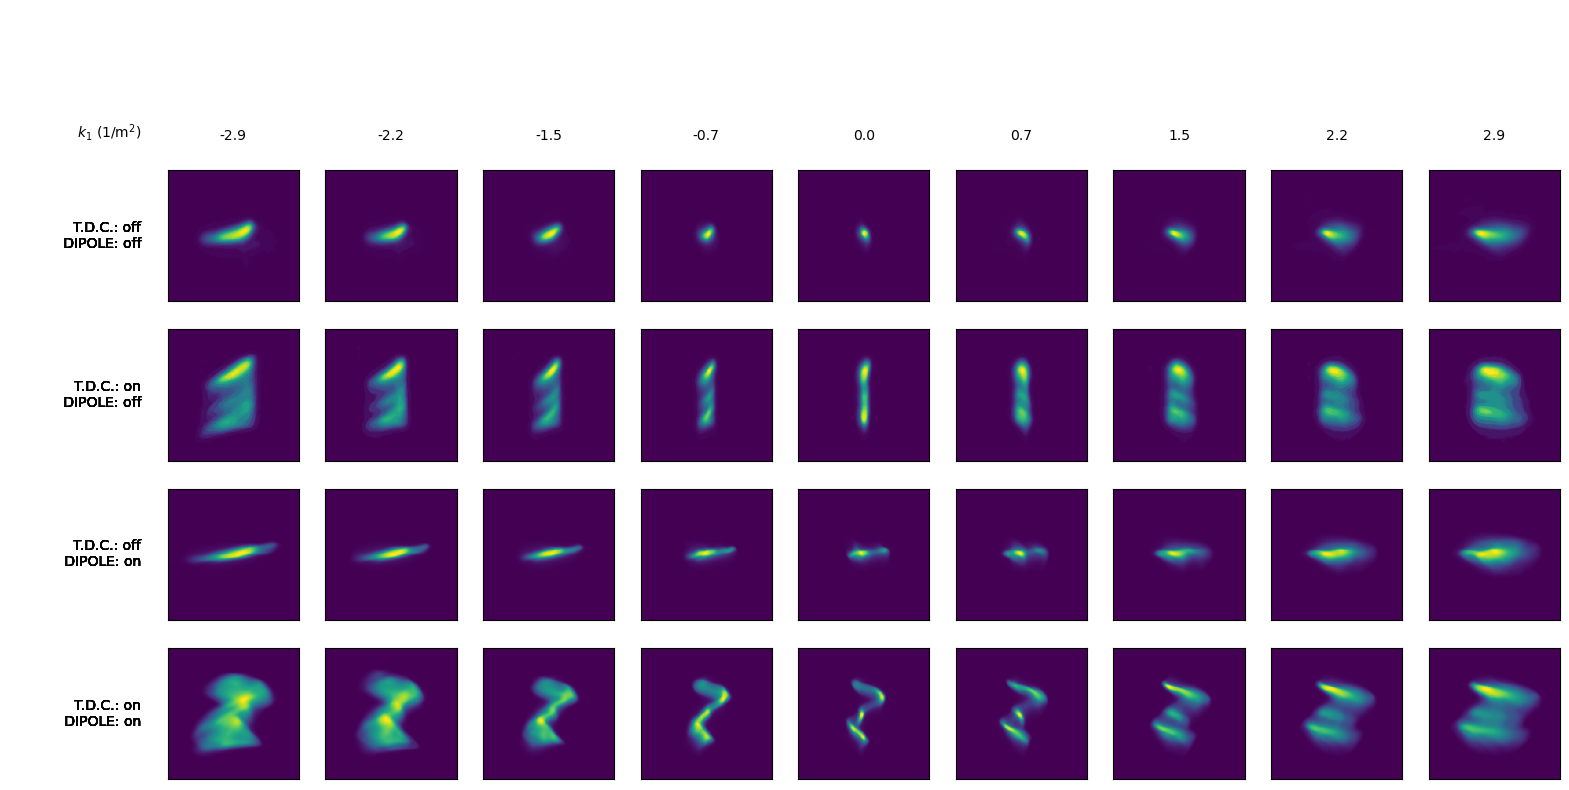

In [6]:
plot_3d_scan_data_2screens(dset)

In [7]:
train_dset, test_dset = split_2screen_dset(dset)

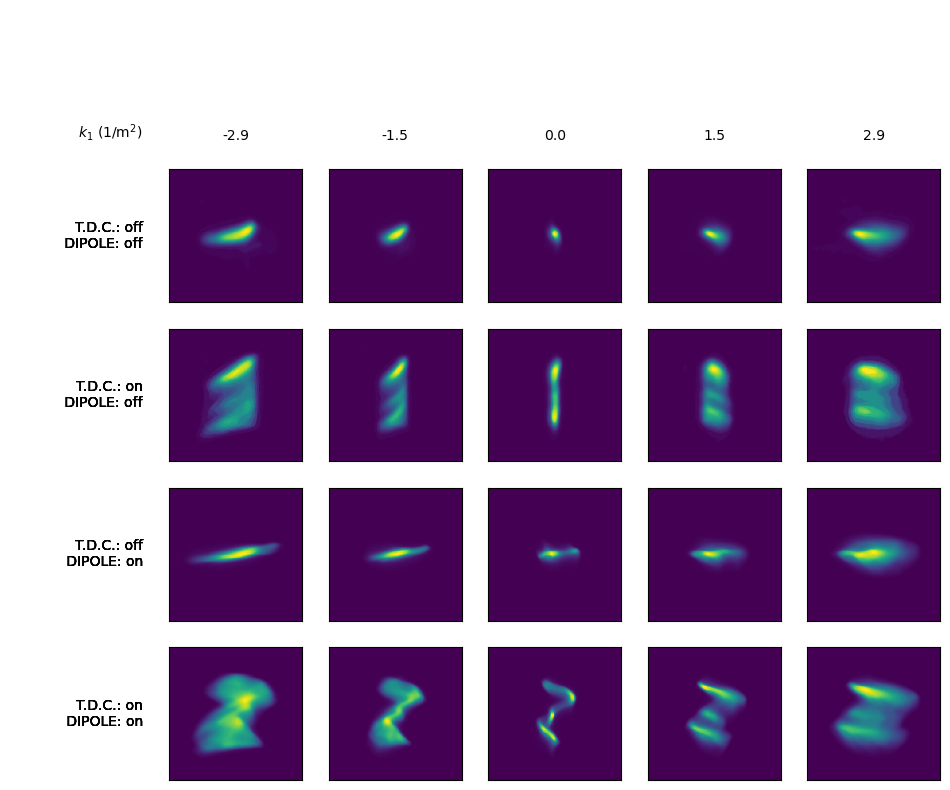

In [8]:
fig, ax = plot_3d_scan_data_2screens(train_dset)
fig.savefig("training_data.png",dpi=300)

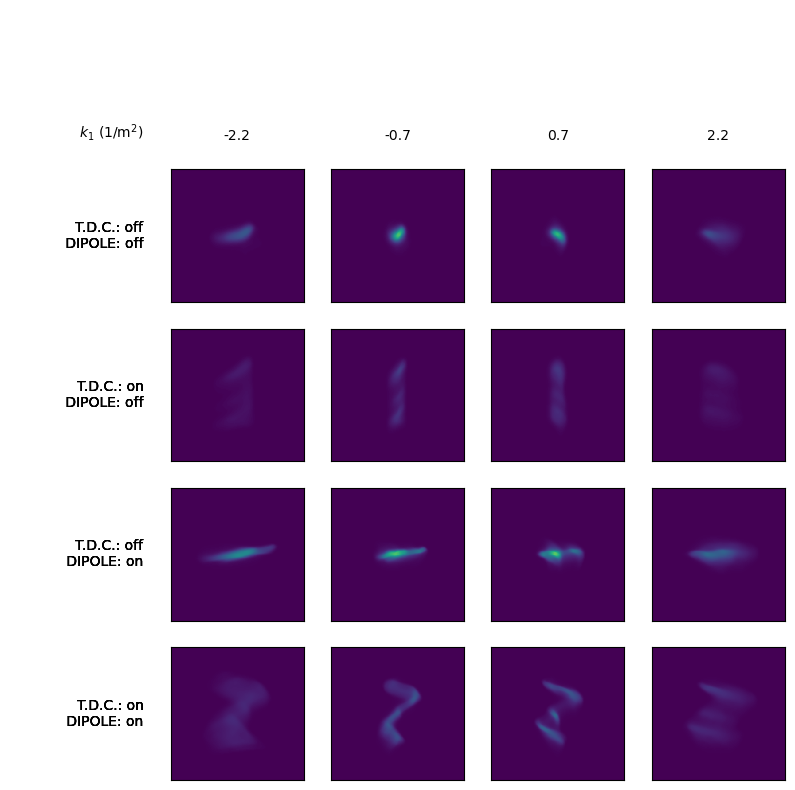

In [9]:
plot_3d_scan_data_2screens(test_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [10]:
from bmadx import Particle
def numpy_to_torch_particles(particle: Particle):
    '''Returns Particle with torch tensors from particles with numpy arrays.'''
    return Particle(
        x = torch.tensor(particle.x),
        px = torch.tensor(particle.px),
        y = torch.tensor(particle.y),
        py = torch.tensor(particle.py),
        z = torch.tensor(particle.z),
        pz = torch.tensor(particle.pz),
        s = torch.tensor(particle.s),
        p0c = torch.tensor(particle.p0c),
        mc2 = torch.tensor(particle.mc2)
    )

In [11]:
pred_beam = numpy_to_torch_particles(torch.load(os.path.join(save_dir, 'dist_3000.pt')))

/tmp/ipykernel_1730359/326284969.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(particle.x),
/tmp/ipykernel_1730359/326284969.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  px = torch.tensor(particle.px),
/tmp/ipykernel_1730359/326284969.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(particle.y),
/tmp/ipykernel_1730359/326284969.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

In [12]:
test_dset.params.shape

torch.Size([4, 2, 2, 3])

In [13]:
# diagnostic beamline:
p0c = 43.3e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)
width = 300
size_0 = 30.22*1e-3*width/700
size_1 = 26.96*1e-3*width/700
screen0 = create_screen(size_0, width)
screen1 = create_screen(size_1, width)

In [14]:
pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=test_dset.params,
    ids=scan_ids
)

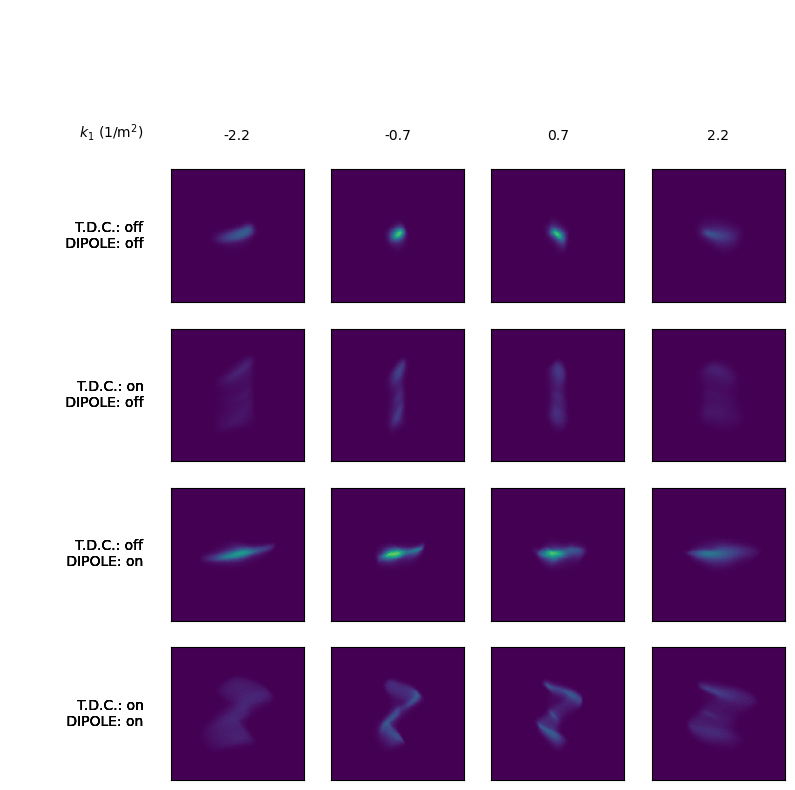

In [15]:
plot_3d_scan_data_2screens(pred_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

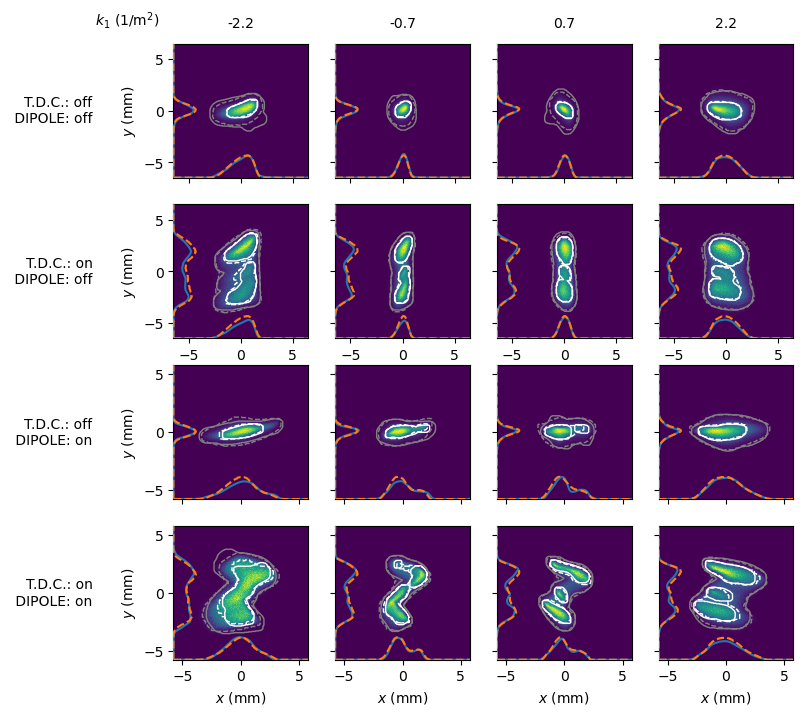

In [16]:
fig,ax = plot_3d_scan_data_2screens_contour(pred_dset, test_dset, screen_0_len = size_0, screen_1_len=size_1)
fig.savefig("exp_results_3000_test_dset.svg", dpi=300)

In [17]:
complete_pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=dset.params,
    ids=scan_ids
)

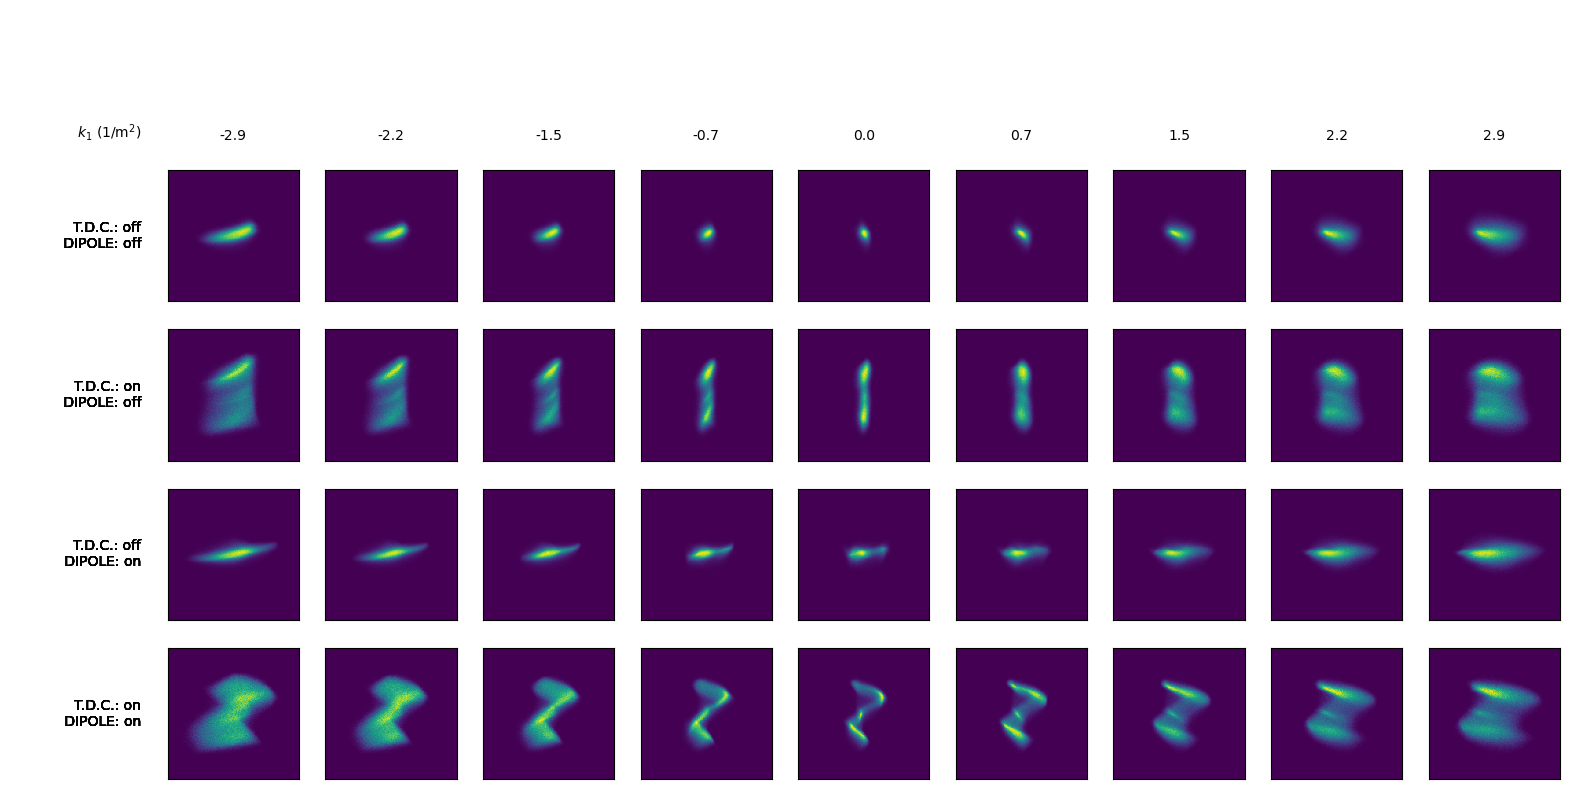

In [18]:
plot_3d_scan_data_2screens(complete_pred_dset)
plt.show()

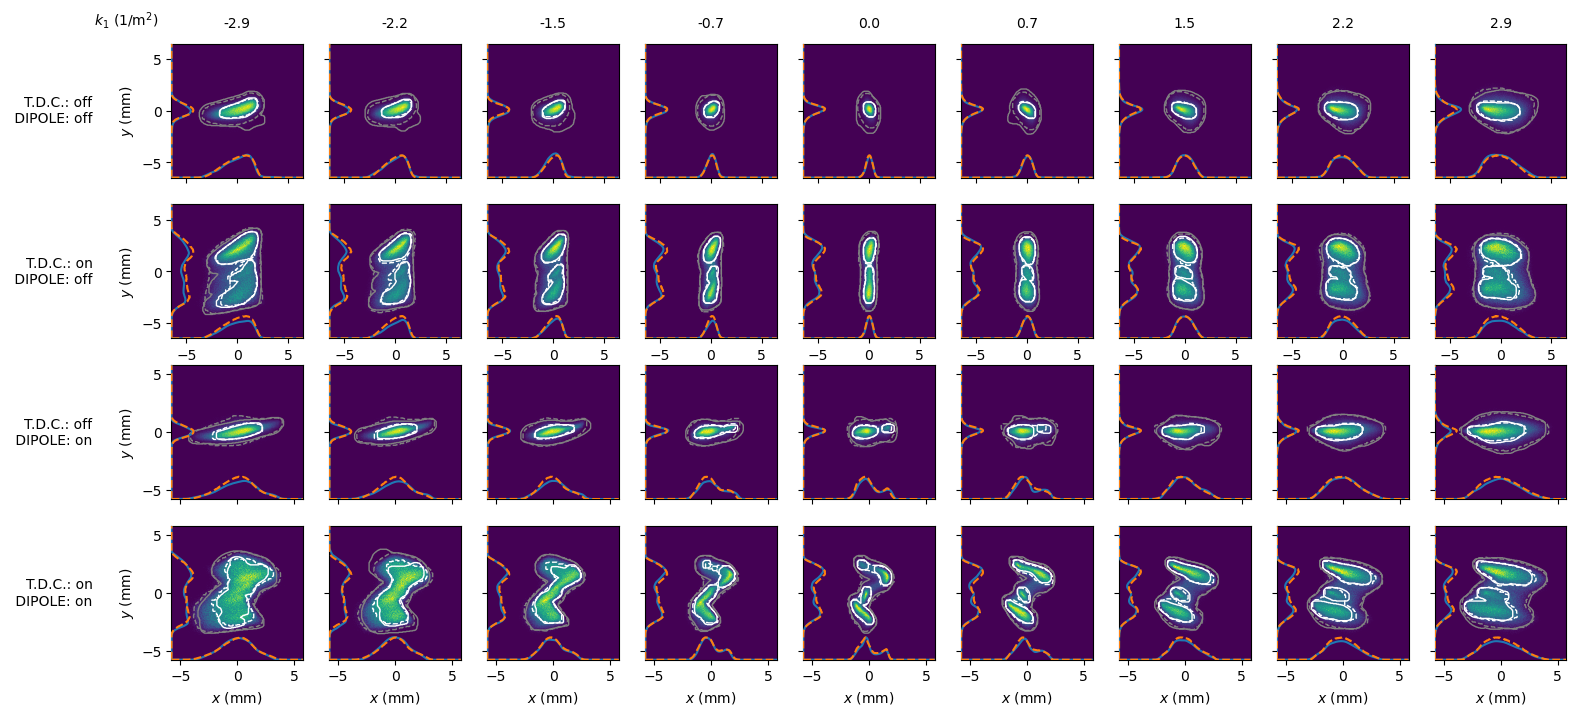

In [19]:
fig, ax = plot_3d_scan_data_2screens_contour(complete_pred_dset, dset, screen_0_len = size_0, screen_1_len=size_1)
fig.savefig("exp_results_3000_complete_dset.svg", dpi=300)
plt.show()

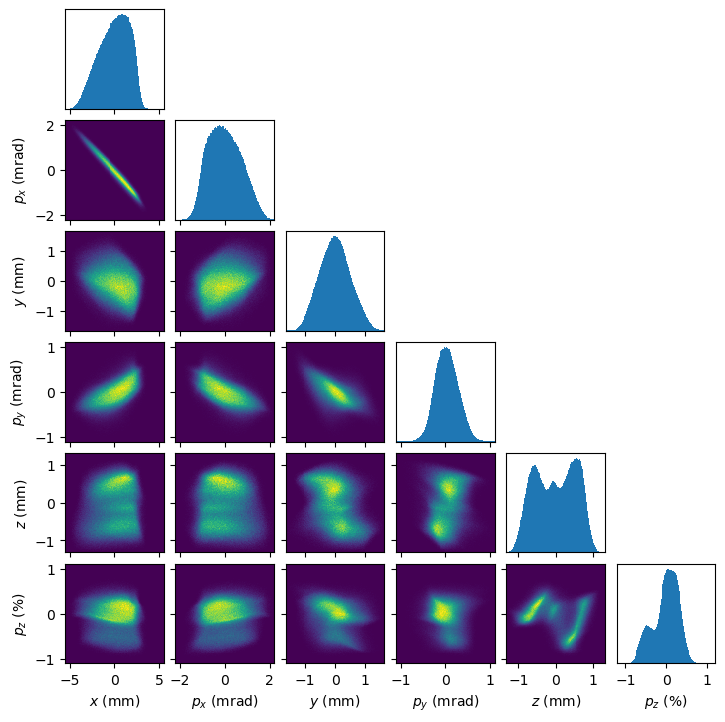

In [20]:
lims = np.array([
    [-5,5],
    [-2,2],
    [-1.5,1.5],
    [-1,1],
    [-1.2,1.2],
    [-10,10]
])*1.1e-3
fig, ax = plot_projections(
    pred_beam,
    custom_lims = lims,
    bins = 100
)
fig.set_size_inches(7,7)
fig.savefig("reconstructed_distribution.png", dpi=300)
fig.savefig("reconstructed_distribution.svg", dpi=300)
plt.show()